In [4]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset
import matplotlib.pyplot as plt

In [5]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [6]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


In [7]:
import copy
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

In [8]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score

# 
approx_train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

approx_train_tracker = torchmetrics.wrappers.MetricTracker(approx_train_collection)
train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)
    

In [9]:
from torch_geometric.seed import seed_everything
seed_everything(42)

kwargs = {'batch_size': 512, 'num_workers': 2, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[50], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # a single conv layer and a single linear layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = x.relu_()
            x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        # pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        # pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                x = x.relu_()
                x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                # pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        # pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')
    
    total_loss = total_examples = 0
    approx_train_tracker.increment() # the start of a new epoch
    
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        logits = model(batch.x, batch.edge_index.to(device))[:batch.batch_size].squeeze(-1)
        
        # create hard label only for confidence proteins and used for binary classification evaluation
        y_pred_prob = torch.nn.functional.sigmoid(logits)
        # y_hard = torch.where(y > 0.99, 1, 
        #                      torch.where(y < 0.5, 0, -1))
        # binary_mask = (y_hard != -1).bool()

        
        loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        approx_train_tracker.update(y_pred_prob, y)
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples



@torch.no_grad()
def test():
    model.eval()
    logits = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)
 
    loss = []
    train_tracker.update(y_pred_prob[data.train_mask], data.y[data.train_mask])
    val_tracker.update(y_pred_prob[data.val_mask], data.y[data.val_mask])
    test_tracker.update(y_pred_prob[data.test_mask], data.y[data.test_mask])
    # train_tracker.update(y_pred_prob[data.train_mask & binary_mask], y_hard[data.train_mask & binary_mask])
    # val_tracker.update(y_pred_prob[data.val_mask & binary_mask], y_hard[data.val_mask & binary_mask])
    # test_tracker.update(y_pred_prob[data.test_mask & binary_mask], y_hard[data.test_mask & binary_mask])
    
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], data.y[mask]))
    
    return loss

In [10]:
approx_train_losses = []
train_losses = []
val_losses = []
test_losses = []

times = []
for epoch in range(1, 30):
    start = time.time()
    
    # Evaluation before first training epoch starts
    train_tracker.increment()
    val_tracker.increment()
    test_tracker.increment()

    train_loss, val_loss, test_loss = test()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_metrics = train_tracker.compute()
    val_metrics = val_tracker.compute()
    test_metrics = test_tracker.compute()
    
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
    print(f'Epoch: {epoch:02d}, Train Acc: {train_metrics["BinaryAccuracy"]:.4f}, Val Acc: {val_metrics["BinaryAccuracy"]:.4f}, '
          f'Test Acc: {test_metrics["BinaryAccuracy"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train AUC: {train_metrics["BinaryAUROC"]:.4f}, Val AUC: {val_metrics["BinaryAUROC"]:.4f}, '
          f'Test AUC: {test_metrics["BinaryAUROC"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train F1: {train_metrics["BinaryF1Score"]:.4f}, Val F1: {val_metrics["BinaryF1Score"]:.4f}, '
            f'Test F1: {test_metrics["BinaryF1Score"]:.4f}')
    
    approx_train_loss = train(epoch)
    approx_train_losses.append(approx_train_loss)
    approx_train_metrics = approx_train_tracker.compute()
    print(f'Epoch {epoch:02d}, Approx train loss: {approx_train_loss:.4f}, Approx. Train Acc: {approx_train_metrics["BinaryAccuracy"]:.4f},'
          f'Approx. Train AUC: {approx_train_metrics["BinaryAUROC"]:.4f}, Approx. Train F1: {approx_train_metrics["BinaryF1Score"]:.4f}')
    
    
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Train Loss: 0.7638, Val Loss: 0.7616, Test Loss: 0.7695
Epoch: 01, Train Acc: 0.3658, Val Acc: 0.3812, Test Acc: 0.3429
Epoch: 01, Train AUC: 0.0931, Val AUC: 0.0906, Test AUC: 0.0816
Epoch: 01, Train F1: 0.5357, Val F1: 0.5520, Test F1: 0.5107


Epoch 01: 100%|██████████| 10029/10029 [00:02<00:00, 4500.11it/s]


Epoch 01, Approx train loss: 0.7548, Approx. Train Acc: 0.2357,Approx. Train AUC: 0.1151, Approx. Train F1: 0.3780
Epoch: 02, Train Loss: 0.7451, Val Loss: 0.7446, Test Loss: 0.7484
Epoch: 02, Train Acc: 0.1805, Val Acc: 0.1786, Test Acc: 0.1667
Epoch: 02, Train AUC: 0.0879, Val AUC: 0.0828, Test AUC: 0.0751
Epoch: 02, Train F1: 0.2913, Val F1: 0.2955, Test F1: 0.2677


Epoch 02: 100%|██████████| 10029/10029 [00:00<00:00, 79712.33it/s]


Epoch 02, Approx train loss: 0.7378, Approx. Train Acc: 0.1595,Approx. Train AUC: 0.1021, Approx. Train F1: 0.2402
Epoch: 03, Train Loss: 0.7302, Val Loss: 0.7311, Test Loss: 0.7315
Epoch: 03, Train Acc: 0.1445, Val Acc: 0.1579, Test Acc: 0.1388
Epoch: 03, Train AUC: 0.0845, Val AUC: 0.0776, Test AUC: 0.0714
Epoch: 03, Train F1: 0.1728, Val F1: 0.2036, Test F1: 0.1549


Epoch 03: 100%|██████████| 10029/10029 [00:00<00:00, 79732.58it/s]


Epoch 03, Approx train loss: 0.7243, Approx. Train Acc: 0.2140,Approx. Train AUC: 0.0965, Approx. Train F1: 0.1017
Epoch: 04, Train Loss: 0.7178, Val Loss: 0.7198, Test Loss: 0.7173
Epoch: 04, Train Acc: 0.3625, Val Acc: 0.3333, Test Acc: 0.3708
Epoch: 04, Train AUC: 0.0817, Val AUC: 0.0738, Test AUC: 0.0684
Epoch: 04, Train F1: 0.0408, Val F1: 0.0302, Test F1: 0.0295


Epoch 04: 100%|██████████| 10029/10029 [00:00<00:00, 80033.55it/s]


Epoch 04, Approx train loss: 0.7126, Approx. Train Acc: 0.4724,Approx. Train AUC: 0.0921, Approx. Train F1: 0.0333
Epoch: 05, Train Loss: 0.7069, Val Loss: 0.7097, Test Loss: 0.7051
Epoch: 05, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 05, Train AUC: 0.0821, Val AUC: 0.0716, Test AUC: 0.0687
Epoch: 05, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 05: 100%|██████████| 10029/10029 [00:00<00:00, 80772.29it/s]


Epoch 05, Approx train loss: 0.7021, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.0989, Approx. Train F1: 0.0000
Epoch: 06, Train Loss: 0.6967, Val Loss: 0.7001, Test Loss: 0.6938
Epoch: 06, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 06, Train AUC: 0.0986, Val AUC: 0.0850, Test AUC: 0.0894
Epoch: 06, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 06: 100%|██████████| 10029/10029 [00:00<00:00, 78989.06it/s]


Epoch 06, Approx train loss: 0.6920, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.1353, Approx. Train F1: 0.0000
Epoch: 07, Train Loss: 0.6865, Val Loss: 0.6904, Test Loss: 0.6828
Epoch: 07, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 07, Train AUC: 0.1771, Val AUC: 0.1490, Test AUC: 0.1644
Epoch: 07, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 07: 100%|██████████| 10029/10029 [00:00<00:00, 80967.10it/s]


Epoch 07, Approx train loss: 0.6815, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.2738, Approx. Train F1: 0.0000
Epoch: 08, Train Loss: 0.6758, Val Loss: 0.6803, Test Loss: 0.6712
Epoch: 08, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 08, Train AUC: 0.3897, Val AUC: 0.3568, Test AUC: 0.3786
Epoch: 08, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 08: 100%|██████████| 10029/10029 [00:00<00:00, 80223.58it/s]


Epoch 08, Approx train loss: 0.6705, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.5137, Approx. Train F1: 0.0000
Epoch: 09, Train Loss: 0.6642, Val Loss: 0.6689, Test Loss: 0.6591
Epoch: 09, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 09, Train AUC: 0.6658, Val AUC: 0.6393, Test AUC: 0.6871
Epoch: 09, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 09: 100%|██████████| 10029/10029 [00:00<00:00, 79057.50it/s]


Epoch 09, Approx train loss: 0.6585, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.7081, Approx. Train F1: 0.0000
Epoch: 10, Train Loss: 0.6512, Val Loss: 0.6562, Test Loss: 0.6454
Epoch: 10, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 10, Train AUC: 0.7403, Val AUC: 0.7150, Test AUC: 0.7540
Epoch: 10, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 10: 100%|██████████| 10029/10029 [00:00<00:00, 79725.63it/s]


Epoch 10, Approx train loss: 0.6449, Approx. Train Acc: 0.6310,Approx. Train AUC: 0.7585, Approx. Train F1: 0.0000
Epoch: 11, Train Loss: 0.6371, Val Loss: 0.6423, Test Loss: 0.6306
Epoch: 11, Train Acc: 0.6310, Val Acc: 0.6172, Test Acc: 0.6539
Epoch: 11, Train AUC: 0.7732, Val AUC: 0.7404, Test AUC: 0.7859
Epoch: 11, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 11: 100%|██████████| 10029/10029 [00:00<00:00, 79721.55it/s]


Epoch 11, Approx train loss: 0.6304, Approx. Train Acc: 0.6556,Approx. Train AUC: 0.7827, Approx. Train F1: 0.1260
Epoch: 12, Train Loss: 0.6221, Val Loss: 0.6273, Test Loss: 0.6151
Epoch: 12, Train Acc: 0.7824, Val Acc: 0.7783, Test Acc: 0.8078
Epoch: 12, Train AUC: 0.7907, Val AUC: 0.7559, Test AUC: 0.8029
Epoch: 12, Train F1: 0.5863, Val F1: 0.5959, Test F1: 0.6240


Epoch 12: 100%|██████████| 10029/10029 [00:00<00:00, 79315.08it/s]


Epoch 12, Approx train loss: 0.6151, Approx. Train Acc: 0.7986,Approx. Train AUC: 0.7994, Approx. Train F1: 0.6330
Epoch: 13, Train Loss: 0.6066, Val Loss: 0.6119, Test Loss: 0.5987
Epoch: 13, Train Acc: 0.8244, Val Acc: 0.8270, Test Acc: 0.8509
Epoch: 13, Train AUC: 0.8032, Val AUC: 0.7689, Test AUC: 0.8131
Epoch: 13, Train F1: 0.6987, Val F1: 0.7133, Test F1: 0.7399


Epoch 13: 100%|██████████| 10029/10029 [00:00<00:00, 79773.25it/s]


Epoch 13, Approx train loss: 0.5994, Approx. Train Acc: 0.8291,Approx. Train AUC: 0.8089, Approx. Train F1: 0.7120
Epoch: 14, Train Loss: 0.5906, Val Loss: 0.5961, Test Loss: 0.5820
Epoch: 14, Train Acc: 0.8316, Val Acc: 0.8317, Test Acc: 0.8573
Epoch: 14, Train AUC: 0.8101, Val AUC: 0.7791, Test AUC: 0.8192
Epoch: 14, Train F1: 0.7207, Val F1: 0.7270, Test F1: 0.7597


Epoch 14: 100%|██████████| 10029/10029 [00:00<00:00, 80460.36it/s]


Epoch 14, Approx train loss: 0.5835, Approx. Train Acc: 0.8337,Approx. Train AUC: 0.8185, Approx. Train F1: 0.7259
Epoch: 15, Train Loss: 0.5746, Val Loss: 0.5801, Test Loss: 0.5652
Epoch: 15, Train Acc: 0.8354, Val Acc: 0.8365, Test Acc: 0.8581
Epoch: 15, Train AUC: 0.8163, Val AUC: 0.7841, Test AUC: 0.8274
Epoch: 15, Train F1: 0.7323, Val F1: 0.7415, Test F1: 0.7633


Epoch 15: 100%|██████████| 10029/10029 [00:00<00:00, 79449.46it/s]


Epoch 15, Approx train loss: 0.5674, Approx. Train Acc: 0.8361,Approx. Train AUC: 0.8259, Approx. Train F1: 0.7354
Epoch: 16, Train Loss: 0.5587, Val Loss: 0.5642, Test Loss: 0.5486
Epoch: 16, Train Acc: 0.8376, Val Acc: 0.8389, Test Acc: 0.8620
Epoch: 16, Train AUC: 0.8196, Val AUC: 0.7868, Test AUC: 0.8303
Epoch: 16, Train F1: 0.7397, Val F1: 0.7481, Test F1: 0.7721


Epoch 16: 100%|██████████| 10029/10029 [00:00<00:00, 81068.53it/s]


Epoch 16, Approx train loss: 0.5516, Approx. Train Acc: 0.8386,Approx. Train AUC: 0.8345, Approx. Train F1: 0.7422
Epoch: 17, Train Loss: 0.5428, Val Loss: 0.5484, Test Loss: 0.5318
Epoch: 17, Train Acc: 0.8391, Val Acc: 0.8397, Test Acc: 0.8628
Epoch: 17, Train AUC: 0.8204, Val AUC: 0.7877, Test AUC: 0.8313
Epoch: 17, Train F1: 0.7441, Val F1: 0.7503, Test F1: 0.7749


Epoch 17: 100%|██████████| 10029/10029 [00:00<00:00, 79325.25it/s]


Epoch 17, Approx train loss: 0.5358, Approx. Train Acc: 0.8392,Approx. Train AUC: 0.8453, Approx. Train F1: 0.7458
Epoch: 18, Train Loss: 0.5273, Val Loss: 0.5329, Test Loss: 0.5156
Epoch: 18, Train Acc: 0.8396, Val Acc: 0.8405, Test Acc: 0.8604
Epoch: 18, Train AUC: 0.8718, Val AUC: 0.8576, Test AUC: 0.8796
Epoch: 18, Train F1: 0.7479, Val F1: 0.7537, Test F1: 0.7724


Epoch 18: 100%|██████████| 10029/10029 [00:00<00:00, 79658.44it/s]


Epoch 18, Approx train loss: 0.5206, Approx. Train Acc: 0.8397,Approx. Train AUC: 0.8612, Approx. Train F1: 0.7484
Epoch: 19, Train Loss: 0.5124, Val Loss: 0.5181, Test Loss: 0.4998
Epoch: 19, Train Acc: 0.8401, Val Acc: 0.8413, Test Acc: 0.8612
Epoch: 19, Train AUC: 0.8786, Val AUC: 0.8638, Test AUC: 0.8879
Epoch: 19, Train F1: 0.7500, Val F1: 0.7552, Test F1: 0.7752


Epoch 19: 100%|██████████| 10029/10029 [00:00<00:00, 80576.26it/s]


Epoch 19, Approx train loss: 0.5058, Approx. Train Acc: 0.8410,Approx. Train AUC: 0.8905, Approx. Train F1: 0.7529
Epoch: 20, Train Loss: 0.4981, Val Loss: 0.5037, Test Loss: 0.4850
Epoch: 20, Train Acc: 0.8414, Val Acc: 0.8397, Test Acc: 0.8581
Epoch: 20, Train AUC: 0.9061, Val AUC: 0.9051, Test AUC: 0.9152
Epoch: 20, Train F1: 0.7541, Val F1: 0.7552, Test F1: 0.7718


Epoch 20: 100%|██████████| 10029/10029 [00:00<00:00, 79441.96it/s]


Epoch 20, Approx train loss: 0.4918, Approx. Train Acc: 0.8419,Approx. Train AUC: 0.8993, Approx. Train F1: 0.7553
Epoch: 21, Train Loss: 0.4844, Val Loss: 0.4900, Test Loss: 0.4705
Epoch: 21, Train Acc: 0.8420, Val Acc: 0.8397, Test Acc: 0.8596
Epoch: 21, Train AUC: 0.9060, Val AUC: 0.9052, Test AUC: 0.9156
Epoch: 21, Train F1: 0.7560, Val F1: 0.7564, Test F1: 0.7749


Epoch 21: 100%|██████████| 10029/10029 [00:00<00:00, 80502.70it/s]


Epoch 21, Approx train loss: 0.4786, Approx. Train Acc: 0.8420,Approx. Train AUC: 0.9007, Approx. Train F1: 0.7561
Epoch: 22, Train Loss: 0.4715, Val Loss: 0.4772, Test Loss: 0.4567
Epoch: 22, Train Acc: 0.8425, Val Acc: 0.8381, Test Acc: 0.8604
Epoch: 22, Train AUC: 0.9046, Val AUC: 0.9040, Test AUC: 0.9146
Epoch: 22, Train F1: 0.7576, Val F1: 0.7545, Test F1: 0.7771


Epoch 22: 100%|██████████| 10029/10029 [00:00<00:00, 79749.81it/s]


Epoch 22, Approx train loss: 0.4660, Approx. Train Acc: 0.8438,Approx. Train AUC: 0.9027, Approx. Train F1: 0.7603
Epoch: 23, Train Loss: 0.4595, Val Loss: 0.4650, Test Loss: 0.4442
Epoch: 23, Train Acc: 0.8445, Val Acc: 0.8357, Test Acc: 0.8628
Epoch: 23, Train AUC: 0.9039, Val AUC: 0.9034, Test AUC: 0.9142
Epoch: 23, Train F1: 0.7618, Val F1: 0.7518, Test F1: 0.7817


Epoch 23: 100%|██████████| 10029/10029 [00:00<00:00, 80137.69it/s]


Epoch 23, Approx train loss: 0.4544, Approx. Train Acc: 0.8440,Approx. Train AUC: 0.9021, Approx. Train F1: 0.7617
Epoch: 24, Train Loss: 0.4483, Val Loss: 0.4537, Test Loss: 0.4324
Epoch: 24, Train Acc: 0.8442, Val Acc: 0.8357, Test Acc: 0.8620
Epoch: 24, Train AUC: 0.9039, Val AUC: 0.9034, Test AUC: 0.9143
Epoch: 24, Train F1: 0.7621, Val F1: 0.7518, Test F1: 0.7813


Epoch 24: 100%|██████████| 10029/10029 [00:00<00:00, 79226.20it/s]


Epoch 24, Approx train loss: 0.4437, Approx. Train Acc: 0.8446,Approx. Train AUC: 0.9015, Approx. Train F1: 0.7628
Epoch: 25, Train Loss: 0.4380, Val Loss: 0.4435, Test Loss: 0.4212
Epoch: 25, Train Acc: 0.8443, Val Acc: 0.8365, Test Acc: 0.8628
Epoch: 25, Train AUC: 0.9043, Val AUC: 0.9039, Test AUC: 0.9146
Epoch: 25, Train F1: 0.7625, Val F1: 0.7527, Test F1: 0.7823


Epoch 25: 100%|██████████| 10029/10029 [00:00<00:00, 79234.26it/s]


Epoch 25, Approx train loss: 0.4337, Approx. Train Acc: 0.8445,Approx. Train AUC: 0.9029, Approx. Train F1: 0.7636
Epoch: 26, Train Loss: 0.4286, Val Loss: 0.4337, Test Loss: 0.4115
Epoch: 26, Train Acc: 0.8443, Val Acc: 0.8357, Test Acc: 0.8628
Epoch: 26, Train AUC: 0.9041, Val AUC: 0.9044, Test AUC: 0.9148
Epoch: 26, Train F1: 0.7638, Val F1: 0.7524, Test F1: 0.7834


Epoch 26: 100%|██████████| 10029/10029 [00:00<00:00, 80326.38it/s]

Epoch 26, Approx train loss: 0.4246, Approx. Train Acc: 0.8448,Approx. Train AUC: 0.9039, Approx. Train F1: 0.7649


Epoch: 27, Train Loss: 0.4200, Val Loss: 0.4250, Test Loss: 0.4023
Epoch: 27, Train Acc: 0.8448, Val Acc: 0.8333, Test Acc: 0.8636
Epoch: 27, Train AUC: 0.9047, Val AUC: 0.9053, Test AUC: 0.9156
Epoch: 27, Train F1: 0.7650, Val F1: 0.7497, Test F1: 0.7854


Epoch 27: 100%|██████████| 10029/10029 [00:00<00:00, 79272.48it/s]

Epoch 27, Approx train loss: 0.4164, Approx. Train Acc: 0.8462,Approx. Train AUC: 0.9038, Approx. Train F1: 0.7674


Epoch: 28, Train Loss: 0.4122, Val Loss: 0.4171, Test Loss: 0.3939
Epoch: 28, Train Acc: 0.8454, Val Acc: 0.8349, Test Acc: 0.8644
Epoch: 28, Train AUC: 0.9052, Val AUC: 0.9062, Test AUC: 0.9163
Epoch: 28, Train F1: 0.7663, Val F1: 0.7527, Test F1: 0.7870


Epoch 28: 100%|██████████| 10029/10029 [00:00<00:00, 78495.13it/s]

Epoch 28, Approx train loss: 0.4091, Approx. Train Acc: 0.8457,Approx. Train AUC: 0.9044, Approx. Train F1: 0.7671


Epoch: 29, Train Loss: 0.4052, Val Loss: 0.4098, Test Loss: 0.3865
Epoch: 29, Train Acc: 0.8451, Val Acc: 0.8349, Test Acc: 0.8652
Epoch: 29, Train AUC: 0.9058, Val AUC: 0.9071, Test AUC: 0.9171
Epoch: 29, Train F1: 0.7666, Val F1: 0.7527, Test F1: 0.7890


Epoch 29: 100%|██████████| 10029/10029 [00:00<00:00, 79893.10it/s]

Epoch 29, Approx train loss: 0.4024, Approx. Train Acc: 0.8444,Approx. Train AUC: 0.9049, Approx. Train F1: 0.7658
Median time per epoch: 0.2327s


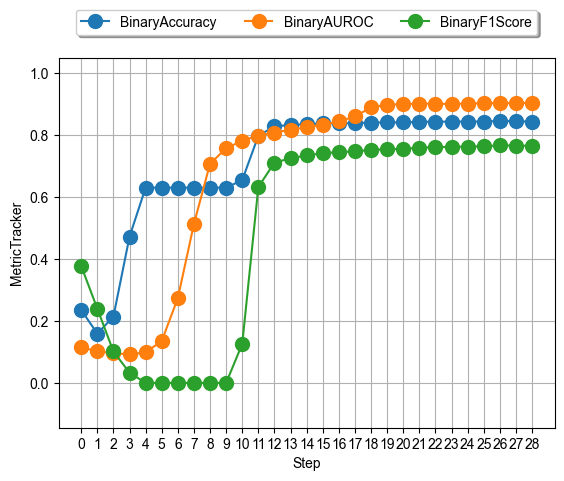

In [15]:
approx_train_tracker.plot()
plt.show()

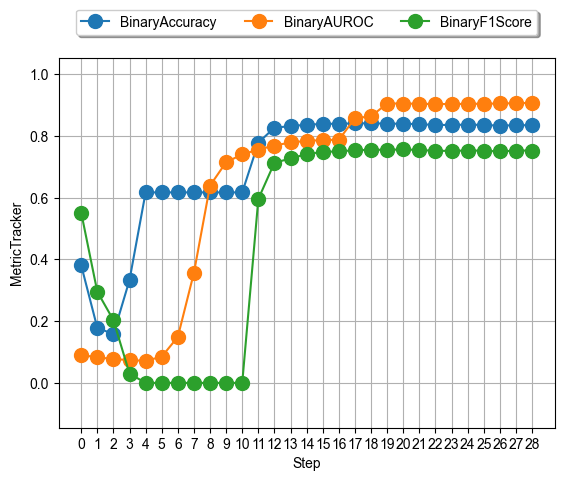

In [16]:
val_tracker.plot()
plt.show()

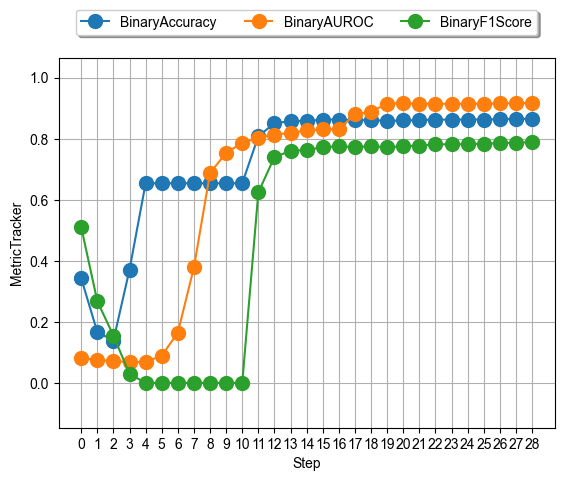

In [17]:
test_tracker.plot()
plt.show()

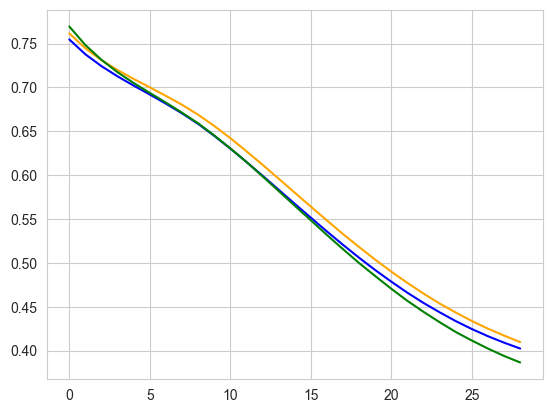

In [14]:
plt.plot(approx_train_losses, color='b')
plt.plot(val_losses, color='orange')
plt.plot(test_losses, color='g')
plt.show()

In [ ]:
test_tracker.plot();
plt.show()

In [3]:
plt.plot(train_tracker.compute_all()['BinaryAUROC'])
plt.plot(val_tracker.compute_all()['BinaryAUROC'])
plt.plot(test_tracker.compute_all()['BinaryAUROC'])
# x-axis label
plt.xlabel('Epoch')
# y-axis label
plt.ylabel('AUROC')
# legend
plt.legend(['Train', 'Validation', 'Test'])
# add  text the largest test AUROC in the plot
plt.text(0.3, 0.5, f"Max test AUROC: {max(test_tracker.compute_all()['BinaryAUROC']):.4f}", transform=plt.gca().transAxes)
# plot a vertical line at the epoch with the largest test AUROC
plt.axvline(x=torch.argmax(test_tracker.compute_all()['BinaryAUROC']), color='r', linestyle='--')
plt.show()

NameError: name 'train_tracker' is not defined

In [23]:
approx_train_tracker.reset_all()
train_tracker.reset_all()
val_tracker.reset_all()
test_tracker.reset_all()